In [ ]:
## Creating Custom Datasets and Finetuning Pre-trained Networks
# In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import sys
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/')
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg')
# print(sys.path)

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision import datasets

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [2]:
use_gpu = False and torch.cuda.is_available()
    
num_classes = 10
batch_size = 20
num_epochs = 5
learning_rate = 0.0002

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        if train:
            root_dir += 'train/'
        else:
            root_dir += 'test/'
        self.imagefolder_dataset = datasets.ImageFolder(root=root_dir,
                                                       transform=transform)
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
        return self.imagefolder_dataset.__len__()
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        image, label = self.imagefolder_dataset.__getitem__(idx)
        return (image, label)

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
<class 'torch.FloatTensor'> torch.Size([20, 3, 224, 224])
Train images
Test images


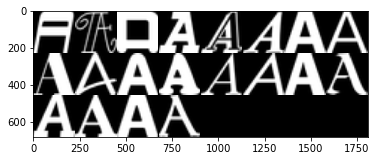

In [4]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='../dataset/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='../dataset/', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
print(type(train_images), train_images.shape)
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [5]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Code to change the last layers so that they only have 10 classes as output
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

Initialize cuda

In [6]:
# Add code for using CUDA here if it is available
if(torch.cuda.is_available() and use_gpu):
    vgg16.cuda()
    resnet18.cuda()

Define loss functions and optimizers

In [7]:
criterion = nn.CrossEntropyLoss()
# Define cross-entropy loss
optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)
# Use Adam optimizer, use learning_rate hyper parameter
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
# Use Adam optimizer, use learning_rate hyper parameter

#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [8]:
def train_vgg16():
    # Write loops so as to train the model for N epochs, use num_epochs hyper parameter
    # Train/finetune the VGG-16 network
    # Store the losses for every epoch and generate a graph using matplotlib
    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer_vgg16.zero_grad()  # zero the gradient buffer
            outputs = vgg16(images)
            print(outputs.dtype)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_vgg16.step()    
            
            running_loss += loss.data[0]
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0])) 
    loss_store += [running_loss]
    plt.plot(loss_store)
    plt.show()
    
def train_resnet18():
    # Same as above except now using the Resnet-18 network

    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer_resnet18.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet18.step()    
            
            running_loss += loss.data[0]
            
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.show()

Now let us start the training/finetuning

Epoch [1/5], Step [1/842], Loss: 2.5009
Epoch [1/5], Step [2/842], Loss: 1.9915
Epoch [1/5], Step [3/842], Loss: 1.8979
Epoch [1/5], Step [4/842], Loss: 1.7519
Epoch [1/5], Step [5/842], Loss: 1.4071
Epoch [1/5], Step [6/842], Loss: 1.1830
Epoch [1/5], Step [7/842], Loss: 1.2088
Epoch [1/5], Step [8/842], Loss: 0.9061
Epoch [1/5], Step [9/842], Loss: 0.8537
Epoch [1/5], Step [10/842], Loss: 1.0340
Epoch [1/5], Step [11/842], Loss: 1.0616
Epoch [1/5], Step [12/842], Loss: 0.9238
Epoch [1/5], Step [13/842], Loss: 0.7575
Epoch [1/5], Step [14/842], Loss: 0.7993
Epoch [1/5], Step [15/842], Loss: 0.4692
Epoch [1/5], Step [16/842], Loss: 0.7674
Epoch [1/5], Step [17/842], Loss: 0.5638
Epoch [1/5], Step [18/842], Loss: 0.7326
Epoch [1/5], Step [19/842], Loss: 0.8194
Epoch [1/5], Step [20/842], Loss: 0.4195
Epoch [1/5], Step [21/842], Loss: 1.1799
Epoch [1/5], Step [22/842], Loss: 0.6664
Epoch [1/5], Step [23/842], Loss: 0.4657
Epoch [1/5], Step [24/842], Loss: 1.0137
Epoch [1/5], Step [25/842

Epoch [1/5], Step [199/842], Loss: 0.2741
Epoch [1/5], Step [200/842], Loss: 0.5439
Epoch [1/5], Step [201/842], Loss: 0.4644
Epoch [1/5], Step [202/842], Loss: 0.1325
Epoch [1/5], Step [203/842], Loss: 0.4391
Epoch [1/5], Step [204/842], Loss: 0.5944
Epoch [1/5], Step [205/842], Loss: 0.2563
Epoch [1/5], Step [206/842], Loss: 0.2896
Epoch [1/5], Step [207/842], Loss: 0.2058
Epoch [1/5], Step [208/842], Loss: 0.1731
Epoch [1/5], Step [209/842], Loss: 0.4148
Epoch [1/5], Step [210/842], Loss: 0.1195
Epoch [1/5], Step [211/842], Loss: 0.1611
Epoch [1/5], Step [212/842], Loss: 0.4790
Epoch [1/5], Step [213/842], Loss: 0.5202
Epoch [1/5], Step [214/842], Loss: 0.1884
Epoch [1/5], Step [215/842], Loss: 0.4506
Epoch [1/5], Step [216/842], Loss: 0.2645
Epoch [1/5], Step [217/842], Loss: 0.1247
Epoch [1/5], Step [218/842], Loss: 0.4335
Epoch [1/5], Step [219/842], Loss: 0.3777
Epoch [1/5], Step [220/842], Loss: 0.1602
Epoch [1/5], Step [221/842], Loss: 0.1731
Epoch [1/5], Step [222/842], Loss:

Epoch [1/5], Step [395/842], Loss: 0.2322
Epoch [1/5], Step [396/842], Loss: 0.2428
Epoch [1/5], Step [397/842], Loss: 0.1637
Epoch [1/5], Step [398/842], Loss: 0.2249
Epoch [1/5], Step [399/842], Loss: 0.1860
Epoch [1/5], Step [400/842], Loss: 0.1273
Epoch [1/5], Step [401/842], Loss: 0.1395
Epoch [1/5], Step [402/842], Loss: 0.3136
Epoch [1/5], Step [403/842], Loss: 0.0429
Epoch [1/5], Step [404/842], Loss: 0.3453
Epoch [1/5], Step [405/842], Loss: 0.4498
Epoch [1/5], Step [406/842], Loss: 0.3213
Epoch [1/5], Step [407/842], Loss: 0.0555
Epoch [1/5], Step [408/842], Loss: 0.2762
Epoch [1/5], Step [409/842], Loss: 0.0402
Epoch [1/5], Step [410/842], Loss: 0.2209
Epoch [1/5], Step [411/842], Loss: 0.1104
Epoch [1/5], Step [412/842], Loss: 0.2226
Epoch [1/5], Step [413/842], Loss: 0.1761
Epoch [1/5], Step [414/842], Loss: 0.2503
Epoch [1/5], Step [415/842], Loss: 0.3019
Epoch [1/5], Step [416/842], Loss: 0.2500
Epoch [1/5], Step [417/842], Loss: 0.5477
Epoch [1/5], Step [418/842], Loss:

Epoch [1/5], Step [591/842], Loss: 0.1648
Epoch [1/5], Step [592/842], Loss: 0.3120
Epoch [1/5], Step [593/842], Loss: 0.2851
Epoch [1/5], Step [594/842], Loss: 0.1563
Epoch [1/5], Step [595/842], Loss: 0.3041
Epoch [1/5], Step [596/842], Loss: 0.1671
Epoch [1/5], Step [597/842], Loss: 0.3826
Epoch [1/5], Step [598/842], Loss: 0.2883
Epoch [1/5], Step [599/842], Loss: 0.1602
Epoch [1/5], Step [600/842], Loss: 0.1421
Epoch [1/5], Step [601/842], Loss: 0.4419
Epoch [1/5], Step [602/842], Loss: 0.1432
Epoch [1/5], Step [603/842], Loss: 0.1907
Epoch [1/5], Step [604/842], Loss: 0.0860
Epoch [1/5], Step [605/842], Loss: 0.1526
Epoch [1/5], Step [606/842], Loss: 0.0679
Epoch [1/5], Step [607/842], Loss: 0.1190
Epoch [1/5], Step [608/842], Loss: 0.6467
Epoch [1/5], Step [609/842], Loss: 0.0571
Epoch [1/5], Step [610/842], Loss: 0.0076
Epoch [1/5], Step [611/842], Loss: 0.2679
Epoch [1/5], Step [612/842], Loss: 0.1471
Epoch [1/5], Step [613/842], Loss: 0.1225
Epoch [1/5], Step [614/842], Loss:

Epoch [1/5], Step [787/842], Loss: 0.2659
Epoch [1/5], Step [788/842], Loss: 0.1280
Epoch [1/5], Step [789/842], Loss: 0.1541
Epoch [1/5], Step [790/842], Loss: 0.1233
Epoch [1/5], Step [791/842], Loss: 0.1593
Epoch [1/5], Step [792/842], Loss: 0.3007
Epoch [1/5], Step [793/842], Loss: 0.1522
Epoch [1/5], Step [794/842], Loss: 0.2443
Epoch [1/5], Step [795/842], Loss: 0.1815
Epoch [1/5], Step [796/842], Loss: 0.1594
Epoch [1/5], Step [797/842], Loss: 0.2212
Epoch [1/5], Step [798/842], Loss: 0.0936
Epoch [1/5], Step [799/842], Loss: 0.0305
Epoch [1/5], Step [800/842], Loss: 0.1100
Epoch [1/5], Step [801/842], Loss: 0.0535
Epoch [1/5], Step [802/842], Loss: 0.0158
Epoch [1/5], Step [803/842], Loss: 0.1235
Epoch [1/5], Step [804/842], Loss: 0.1789
Epoch [1/5], Step [805/842], Loss: 0.2418
Epoch [1/5], Step [806/842], Loss: 0.1440
Epoch [1/5], Step [807/842], Loss: 0.3623
Epoch [1/5], Step [808/842], Loss: 0.3363
Epoch [1/5], Step [809/842], Loss: 0.3026
Epoch [1/5], Step [810/842], Loss:

Epoch [2/5], Step [142/842], Loss: 0.0873
Epoch [2/5], Step [143/842], Loss: 0.0812
Epoch [2/5], Step [144/842], Loss: 0.3432
Epoch [2/5], Step [145/842], Loss: 0.0322
Epoch [2/5], Step [146/842], Loss: 0.2147
Epoch [2/5], Step [147/842], Loss: 0.0041
Epoch [2/5], Step [148/842], Loss: 0.0444
Epoch [2/5], Step [149/842], Loss: 0.2519
Epoch [2/5], Step [150/842], Loss: 0.4083
Epoch [2/5], Step [151/842], Loss: 0.0900
Epoch [2/5], Step [152/842], Loss: 0.1216
Epoch [2/5], Step [153/842], Loss: 0.2561
Epoch [2/5], Step [154/842], Loss: 0.1962
Epoch [2/5], Step [155/842], Loss: 0.0054
Epoch [2/5], Step [156/842], Loss: 0.0144
Epoch [2/5], Step [157/842], Loss: 0.0376
Epoch [2/5], Step [158/842], Loss: 0.2477
Epoch [2/5], Step [159/842], Loss: 0.1033
Epoch [2/5], Step [160/842], Loss: 0.1199
Epoch [2/5], Step [161/842], Loss: 0.2587
Epoch [2/5], Step [162/842], Loss: 0.0041
Epoch [2/5], Step [163/842], Loss: 0.1267
Epoch [2/5], Step [164/842], Loss: 0.0063
Epoch [2/5], Step [165/842], Loss:

Epoch [2/5], Step [338/842], Loss: 0.2231
Epoch [2/5], Step [339/842], Loss: 0.0892
Epoch [2/5], Step [340/842], Loss: 0.1526
Epoch [2/5], Step [341/842], Loss: 0.1099
Epoch [2/5], Step [342/842], Loss: 0.2660
Epoch [2/5], Step [343/842], Loss: 0.0174
Epoch [2/5], Step [344/842], Loss: 0.0365
Epoch [2/5], Step [345/842], Loss: 0.0213
Epoch [2/5], Step [346/842], Loss: 0.2960
Epoch [2/5], Step [347/842], Loss: 0.0371
Epoch [2/5], Step [348/842], Loss: 0.0168
Epoch [2/5], Step [349/842], Loss: 0.0811
Epoch [2/5], Step [350/842], Loss: 0.0748
Epoch [2/5], Step [351/842], Loss: 0.0467
Epoch [2/5], Step [352/842], Loss: 0.0391
Epoch [2/5], Step [353/842], Loss: 0.0737
Epoch [2/5], Step [354/842], Loss: 0.1727
Epoch [2/5], Step [355/842], Loss: 0.0077
Epoch [2/5], Step [356/842], Loss: 0.0512
Epoch [2/5], Step [357/842], Loss: 0.2490
Epoch [2/5], Step [358/842], Loss: 0.1719
Epoch [2/5], Step [359/842], Loss: 0.1239
Epoch [2/5], Step [360/842], Loss: 0.2942
Epoch [2/5], Step [361/842], Loss:

Epoch [2/5], Step [534/842], Loss: 0.0660
Epoch [2/5], Step [535/842], Loss: 0.2262
Epoch [2/5], Step [536/842], Loss: 0.3355
Epoch [2/5], Step [537/842], Loss: 0.2054
Epoch [2/5], Step [538/842], Loss: 0.0840
Epoch [2/5], Step [539/842], Loss: 0.0024
Epoch [2/5], Step [540/842], Loss: 0.4149
Epoch [2/5], Step [541/842], Loss: 0.0262
Epoch [2/5], Step [542/842], Loss: 0.2421
Epoch [2/5], Step [543/842], Loss: 0.1098
Epoch [2/5], Step [544/842], Loss: 0.1564
Epoch [2/5], Step [545/842], Loss: 0.0220
Epoch [2/5], Step [546/842], Loss: 0.1440
Epoch [2/5], Step [547/842], Loss: 0.1648
Epoch [2/5], Step [548/842], Loss: 0.1800
Epoch [2/5], Step [549/842], Loss: 0.2124
Epoch [2/5], Step [550/842], Loss: 0.1293
Epoch [2/5], Step [551/842], Loss: 0.4466
Epoch [2/5], Step [552/842], Loss: 0.0320
Epoch [2/5], Step [553/842], Loss: 0.0234
Epoch [2/5], Step [554/842], Loss: 0.0189
Epoch [2/5], Step [555/842], Loss: 0.0729
Epoch [2/5], Step [556/842], Loss: 0.0911
Epoch [2/5], Step [557/842], Loss:

Epoch [2/5], Step [730/842], Loss: 0.2966
Epoch [2/5], Step [731/842], Loss: 0.1375
Epoch [2/5], Step [732/842], Loss: 0.3337
Epoch [2/5], Step [733/842], Loss: 0.1797
Epoch [2/5], Step [734/842], Loss: 0.2419
Epoch [2/5], Step [735/842], Loss: 0.0609
Epoch [2/5], Step [736/842], Loss: 0.2525
Epoch [2/5], Step [737/842], Loss: 0.1524
Epoch [2/5], Step [738/842], Loss: 0.2440
Epoch [2/5], Step [739/842], Loss: 0.0431
Epoch [2/5], Step [740/842], Loss: 0.0485
Epoch [2/5], Step [741/842], Loss: 0.0286
Epoch [2/5], Step [742/842], Loss: 0.4476
Epoch [2/5], Step [743/842], Loss: 0.0683
Epoch [2/5], Step [744/842], Loss: 0.2501
Epoch [2/5], Step [745/842], Loss: 0.1542
Epoch [2/5], Step [746/842], Loss: 0.7460
Epoch [2/5], Step [747/842], Loss: 0.2111
Epoch [2/5], Step [748/842], Loss: 0.2173
Epoch [2/5], Step [749/842], Loss: 0.2229
Epoch [2/5], Step [750/842], Loss: 0.0871
Epoch [2/5], Step [751/842], Loss: 0.1638
Epoch [2/5], Step [752/842], Loss: 0.0865
Epoch [2/5], Step [753/842], Loss:

Epoch [3/5], Step [85/842], Loss: 0.0830
Epoch [3/5], Step [86/842], Loss: 0.0872
Epoch [3/5], Step [87/842], Loss: 0.0023
Epoch [3/5], Step [88/842], Loss: 0.1276
Epoch [3/5], Step [89/842], Loss: 0.1078
Epoch [3/5], Step [90/842], Loss: 0.0928
Epoch [3/5], Step [91/842], Loss: 0.0626
Epoch [3/5], Step [92/842], Loss: 0.0171
Epoch [3/5], Step [93/842], Loss: 0.0248
Epoch [3/5], Step [94/842], Loss: 0.0044
Epoch [3/5], Step [95/842], Loss: 0.0548
Epoch [3/5], Step [96/842], Loss: 0.2111
Epoch [3/5], Step [97/842], Loss: 0.0187
Epoch [3/5], Step [98/842], Loss: 0.0039
Epoch [3/5], Step [99/842], Loss: 0.3649
Epoch [3/5], Step [100/842], Loss: 0.1759
Epoch [3/5], Step [101/842], Loss: 0.0355
Epoch [3/5], Step [102/842], Loss: 0.1004
Epoch [3/5], Step [103/842], Loss: 0.0515
Epoch [3/5], Step [104/842], Loss: 0.0073
Epoch [3/5], Step [105/842], Loss: 0.0183
Epoch [3/5], Step [106/842], Loss: 0.1176
Epoch [3/5], Step [107/842], Loss: 0.1102
Epoch [3/5], Step [108/842], Loss: 0.0791
Epoch [

Epoch [3/5], Step [281/842], Loss: 0.0209
Epoch [3/5], Step [282/842], Loss: 0.3778
Epoch [3/5], Step [283/842], Loss: 0.0790
Epoch [3/5], Step [284/842], Loss: 0.0482
Epoch [3/5], Step [285/842], Loss: 0.1261
Epoch [3/5], Step [286/842], Loss: 0.0056
Epoch [3/5], Step [287/842], Loss: 0.0869
Epoch [3/5], Step [288/842], Loss: 0.3328
Epoch [3/5], Step [289/842], Loss: 0.0414
Epoch [3/5], Step [290/842], Loss: 0.0891
Epoch [3/5], Step [291/842], Loss: 0.0887
Epoch [3/5], Step [292/842], Loss: 0.1328
Epoch [3/5], Step [293/842], Loss: 0.1189
Epoch [3/5], Step [294/842], Loss: 0.0769
Epoch [3/5], Step [295/842], Loss: 0.0532
Epoch [3/5], Step [296/842], Loss: 0.0285
Epoch [3/5], Step [297/842], Loss: 0.0173
Epoch [3/5], Step [298/842], Loss: 0.0638
Epoch [3/5], Step [299/842], Loss: 0.0382
Epoch [3/5], Step [300/842], Loss: 0.6376
Epoch [3/5], Step [301/842], Loss: 0.0614
Epoch [3/5], Step [302/842], Loss: 0.1226
Epoch [3/5], Step [303/842], Loss: 0.0407
Epoch [3/5], Step [304/842], Loss:

Epoch [3/5], Step [477/842], Loss: 0.0593
Epoch [3/5], Step [478/842], Loss: 0.0717
Epoch [3/5], Step [479/842], Loss: 0.0520
Epoch [3/5], Step [480/842], Loss: 0.0804
Epoch [3/5], Step [481/842], Loss: 0.0566
Epoch [3/5], Step [482/842], Loss: 0.0279
Epoch [3/5], Step [483/842], Loss: 0.0622
Epoch [3/5], Step [484/842], Loss: 0.0309
Epoch [3/5], Step [485/842], Loss: 0.0079
Epoch [3/5], Step [486/842], Loss: 0.0166
Epoch [3/5], Step [487/842], Loss: 0.0394
Epoch [3/5], Step [488/842], Loss: 0.0476
Epoch [3/5], Step [489/842], Loss: 0.0967
Epoch [3/5], Step [490/842], Loss: 0.2466
Epoch [3/5], Step [491/842], Loss: 0.0751
Epoch [3/5], Step [492/842], Loss: 0.1890
Epoch [3/5], Step [493/842], Loss: 0.0053
Epoch [3/5], Step [494/842], Loss: 0.0425
Epoch [3/5], Step [495/842], Loss: 0.0850
Epoch [3/5], Step [496/842], Loss: 0.0329
Epoch [3/5], Step [497/842], Loss: 0.0010
Epoch [3/5], Step [498/842], Loss: 0.2328
Epoch [3/5], Step [499/842], Loss: 0.3636
Epoch [3/5], Step [500/842], Loss:

Epoch [3/5], Step [673/842], Loss: 0.0165
Epoch [3/5], Step [674/842], Loss: 0.0268
Epoch [3/5], Step [675/842], Loss: 0.2840
Epoch [3/5], Step [676/842], Loss: 0.1054
Epoch [3/5], Step [677/842], Loss: 0.0069
Epoch [3/5], Step [678/842], Loss: 0.2273
Epoch [3/5], Step [679/842], Loss: 0.3322
Epoch [3/5], Step [680/842], Loss: 0.0022
Epoch [3/5], Step [681/842], Loss: 0.0119
Epoch [3/5], Step [682/842], Loss: 0.2047
Epoch [3/5], Step [683/842], Loss: 0.1727
Epoch [3/5], Step [684/842], Loss: 0.0088
Epoch [3/5], Step [685/842], Loss: 0.3211
Epoch [3/5], Step [686/842], Loss: 0.0582
Epoch [3/5], Step [687/842], Loss: 0.0425
Epoch [3/5], Step [688/842], Loss: 0.0738
Epoch [3/5], Step [689/842], Loss: 0.2956
Epoch [3/5], Step [690/842], Loss: 0.0470
Epoch [3/5], Step [691/842], Loss: 0.1893
Epoch [3/5], Step [692/842], Loss: 0.0240
Epoch [3/5], Step [693/842], Loss: 0.1866
Epoch [3/5], Step [694/842], Loss: 0.1122
Epoch [3/5], Step [695/842], Loss: 0.1379
Epoch [3/5], Step [696/842], Loss:

Epoch [4/5], Step [26/842], Loss: 0.0192
Epoch [4/5], Step [27/842], Loss: 0.0058
Epoch [4/5], Step [28/842], Loss: 0.0201
Epoch [4/5], Step [29/842], Loss: 0.0394
Epoch [4/5], Step [30/842], Loss: 0.1875
Epoch [4/5], Step [31/842], Loss: 0.0934
Epoch [4/5], Step [32/842], Loss: 0.1472
Epoch [4/5], Step [33/842], Loss: 0.0961
Epoch [4/5], Step [34/842], Loss: 0.0900
Epoch [4/5], Step [35/842], Loss: 0.0147
Epoch [4/5], Step [36/842], Loss: 0.0040
Epoch [4/5], Step [37/842], Loss: 0.0652
Epoch [4/5], Step [38/842], Loss: 0.0240
Epoch [4/5], Step [39/842], Loss: 0.0148
Epoch [4/5], Step [40/842], Loss: 0.1544
Epoch [4/5], Step [41/842], Loss: 0.0285
Epoch [4/5], Step [42/842], Loss: 0.1209
Epoch [4/5], Step [43/842], Loss: 0.1262
Epoch [4/5], Step [44/842], Loss: 0.0920
Epoch [4/5], Step [45/842], Loss: 0.0131
Epoch [4/5], Step [46/842], Loss: 0.1284
Epoch [4/5], Step [47/842], Loss: 0.0058
Epoch [4/5], Step [48/842], Loss: 0.0038
Epoch [4/5], Step [49/842], Loss: 0.0203
Epoch [4/5], Ste

Epoch [4/5], Step [223/842], Loss: 0.2699
Epoch [4/5], Step [224/842], Loss: 0.0385
Epoch [4/5], Step [225/842], Loss: 0.0766
Epoch [4/5], Step [226/842], Loss: 0.1066
Epoch [4/5], Step [227/842], Loss: 0.0078
Epoch [4/5], Step [228/842], Loss: 0.0331
Epoch [4/5], Step [229/842], Loss: 0.2142
Epoch [4/5], Step [230/842], Loss: 0.0224
Epoch [4/5], Step [231/842], Loss: 0.0653
Epoch [4/5], Step [232/842], Loss: 0.0102
Epoch [4/5], Step [233/842], Loss: 0.0123
Epoch [4/5], Step [234/842], Loss: 0.0684
Epoch [4/5], Step [235/842], Loss: 0.0104
Epoch [4/5], Step [236/842], Loss: 0.0151
Epoch [4/5], Step [237/842], Loss: 0.0223
Epoch [4/5], Step [238/842], Loss: 0.0230
Epoch [4/5], Step [239/842], Loss: 0.0010
Epoch [4/5], Step [240/842], Loss: 0.1457
Epoch [4/5], Step [241/842], Loss: 0.0062
Epoch [4/5], Step [242/842], Loss: 0.0062
Epoch [4/5], Step [243/842], Loss: 0.2005
Epoch [4/5], Step [244/842], Loss: 0.0341
Epoch [4/5], Step [245/842], Loss: 0.1498
Epoch [4/5], Step [246/842], Loss:

Epoch [4/5], Step [419/842], Loss: 0.0026
Epoch [4/5], Step [420/842], Loss: 0.0571
Epoch [4/5], Step [421/842], Loss: 0.1608
Epoch [4/5], Step [422/842], Loss: 0.0128
Epoch [4/5], Step [423/842], Loss: 0.0219
Epoch [4/5], Step [424/842], Loss: 0.0673
Epoch [4/5], Step [425/842], Loss: 0.3015
Epoch [4/5], Step [426/842], Loss: 0.0636
Epoch [4/5], Step [427/842], Loss: 0.3171
Epoch [4/5], Step [428/842], Loss: 0.0062
Epoch [4/5], Step [429/842], Loss: 0.0074
Epoch [4/5], Step [430/842], Loss: 0.1388
Epoch [4/5], Step [431/842], Loss: 0.0083
Epoch [4/5], Step [432/842], Loss: 0.0329
Epoch [4/5], Step [433/842], Loss: 0.0401
Epoch [4/5], Step [434/842], Loss: 0.0674
Epoch [4/5], Step [435/842], Loss: 0.0396
Epoch [4/5], Step [436/842], Loss: 0.0075
Epoch [4/5], Step [437/842], Loss: 0.0199
Epoch [4/5], Step [438/842], Loss: 0.2186
Epoch [4/5], Step [439/842], Loss: 0.0900
Epoch [4/5], Step [440/842], Loss: 0.0032
Epoch [4/5], Step [441/842], Loss: 0.1042
Epoch [4/5], Step [442/842], Loss:

Epoch [4/5], Step [615/842], Loss: 0.1993
Epoch [4/5], Step [616/842], Loss: 0.0332
Epoch [4/5], Step [617/842], Loss: 0.3790
Epoch [4/5], Step [618/842], Loss: 0.1182
Epoch [4/5], Step [619/842], Loss: 0.1095
Epoch [4/5], Step [620/842], Loss: 0.0784
Epoch [4/5], Step [621/842], Loss: 0.0444
Epoch [4/5], Step [622/842], Loss: 0.1628
Epoch [4/5], Step [623/842], Loss: 0.0100
Epoch [4/5], Step [624/842], Loss: 0.1964
Epoch [4/5], Step [625/842], Loss: 0.0833
Epoch [4/5], Step [626/842], Loss: 0.0254
Epoch [4/5], Step [627/842], Loss: 0.0076
Epoch [4/5], Step [628/842], Loss: 0.1504
Epoch [4/5], Step [629/842], Loss: 0.0377
Epoch [4/5], Step [630/842], Loss: 0.0682
Epoch [4/5], Step [631/842], Loss: 0.0142
Epoch [4/5], Step [632/842], Loss: 0.0177
Epoch [4/5], Step [633/842], Loss: 0.0803
Epoch [4/5], Step [634/842], Loss: 0.1773
Epoch [4/5], Step [635/842], Loss: 0.1609
Epoch [4/5], Step [636/842], Loss: 0.0108
Epoch [4/5], Step [637/842], Loss: 0.1432
Epoch [4/5], Step [638/842], Loss:

Epoch [4/5], Step [811/842], Loss: 0.0127
Epoch [4/5], Step [812/842], Loss: 0.0075
Epoch [4/5], Step [813/842], Loss: 0.0594
Epoch [4/5], Step [814/842], Loss: 0.1937
Epoch [4/5], Step [815/842], Loss: 0.0372
Epoch [4/5], Step [816/842], Loss: 0.1618
Epoch [4/5], Step [817/842], Loss: 0.0735
Epoch [4/5], Step [818/842], Loss: 0.0443
Epoch [4/5], Step [819/842], Loss: 0.0511
Epoch [4/5], Step [820/842], Loss: 0.0151
Epoch [4/5], Step [821/842], Loss: 0.0463
Epoch [4/5], Step [822/842], Loss: 0.6182
Epoch [4/5], Step [823/842], Loss: 0.0351
Epoch [4/5], Step [824/842], Loss: 0.2563
Epoch [4/5], Step [825/842], Loss: 0.3183
Epoch [4/5], Step [826/842], Loss: 0.0661
Epoch [4/5], Step [827/842], Loss: 0.0681
Epoch [4/5], Step [828/842], Loss: 0.2096
Epoch [4/5], Step [829/842], Loss: 0.3072
Epoch [4/5], Step [830/842], Loss: 0.1460
Epoch [4/5], Step [831/842], Loss: 0.2745
Epoch [4/5], Step [832/842], Loss: 0.1265
Epoch [4/5], Step [833/842], Loss: 0.0312
Epoch [4/5], Step [834/842], Loss:

Epoch [5/5], Step [166/842], Loss: 0.0261
Epoch [5/5], Step [167/842], Loss: 0.0145
Epoch [5/5], Step [168/842], Loss: 0.0108
Epoch [5/5], Step [169/842], Loss: 0.0104
Epoch [5/5], Step [170/842], Loss: 0.0080
Epoch [5/5], Step [171/842], Loss: 0.0024
Epoch [5/5], Step [172/842], Loss: 0.0036
Epoch [5/5], Step [173/842], Loss: 0.0094
Epoch [5/5], Step [174/842], Loss: 0.0294
Epoch [5/5], Step [175/842], Loss: 0.0025
Epoch [5/5], Step [176/842], Loss: 0.0053
Epoch [5/5], Step [177/842], Loss: 0.0014
Epoch [5/5], Step [178/842], Loss: 0.0225
Epoch [5/5], Step [179/842], Loss: 0.0332
Epoch [5/5], Step [180/842], Loss: 0.0052
Epoch [5/5], Step [181/842], Loss: 0.0055
Epoch [5/5], Step [182/842], Loss: 0.0011
Epoch [5/5], Step [183/842], Loss: 0.0121
Epoch [5/5], Step [184/842], Loss: 0.0412
Epoch [5/5], Step [185/842], Loss: 0.0681
Epoch [5/5], Step [186/842], Loss: 0.0796
Epoch [5/5], Step [187/842], Loss: 0.0177
Epoch [5/5], Step [188/842], Loss: 0.2229
Epoch [5/5], Step [189/842], Loss:

Epoch [5/5], Step [362/842], Loss: 0.1476
Epoch [5/5], Step [363/842], Loss: 0.1997
Epoch [5/5], Step [364/842], Loss: 0.0364
Epoch [5/5], Step [365/842], Loss: 0.1251
Epoch [5/5], Step [366/842], Loss: 0.0862
Epoch [5/5], Step [367/842], Loss: 0.3018
Epoch [5/5], Step [368/842], Loss: 0.0165
Epoch [5/5], Step [369/842], Loss: 0.0128
Epoch [5/5], Step [370/842], Loss: 0.0011
Epoch [5/5], Step [371/842], Loss: 0.0081
Epoch [5/5], Step [372/842], Loss: 0.1799
Epoch [5/5], Step [373/842], Loss: 0.0441
Epoch [5/5], Step [374/842], Loss: 0.0317
Epoch [5/5], Step [375/842], Loss: 0.0015
Epoch [5/5], Step [376/842], Loss: 0.1339
Epoch [5/5], Step [377/842], Loss: 0.0031
Epoch [5/5], Step [378/842], Loss: 0.0396
Epoch [5/5], Step [379/842], Loss: 0.0111
Epoch [5/5], Step [380/842], Loss: 0.0660
Epoch [5/5], Step [381/842], Loss: 0.0796
Epoch [5/5], Step [382/842], Loss: 0.0052
Epoch [5/5], Step [383/842], Loss: 0.0677
Epoch [5/5], Step [384/842], Loss: 0.1792
Epoch [5/5], Step [385/842], Loss:

Epoch [5/5], Step [558/842], Loss: 0.0073
Epoch [5/5], Step [559/842], Loss: 0.2061
Epoch [5/5], Step [560/842], Loss: 0.0055
Epoch [5/5], Step [561/842], Loss: 0.0272
Epoch [5/5], Step [562/842], Loss: 0.0084
Epoch [5/5], Step [563/842], Loss: 0.2838
Epoch [5/5], Step [564/842], Loss: 0.0209
Epoch [5/5], Step [565/842], Loss: 0.1359
Epoch [5/5], Step [566/842], Loss: 0.0111
Epoch [5/5], Step [567/842], Loss: 0.0031
Epoch [5/5], Step [568/842], Loss: 0.2043
Epoch [5/5], Step [569/842], Loss: 0.0044
Epoch [5/5], Step [570/842], Loss: 0.0276
Epoch [5/5], Step [571/842], Loss: 0.0063
Epoch [5/5], Step [572/842], Loss: 0.0229
Epoch [5/5], Step [573/842], Loss: 0.1443
Epoch [5/5], Step [574/842], Loss: 0.0081
Epoch [5/5], Step [575/842], Loss: 0.0698
Epoch [5/5], Step [576/842], Loss: 0.0046
Epoch [5/5], Step [577/842], Loss: 0.0031
Epoch [5/5], Step [578/842], Loss: 0.0128
Epoch [5/5], Step [579/842], Loss: 0.0377
Epoch [5/5], Step [580/842], Loss: 0.0687
Epoch [5/5], Step [581/842], Loss:

Epoch [5/5], Step [754/842], Loss: 0.2954
Epoch [5/5], Step [755/842], Loss: 0.0071
Epoch [5/5], Step [756/842], Loss: 0.0622
Epoch [5/5], Step [757/842], Loss: 0.0460
Epoch [5/5], Step [758/842], Loss: 0.1655
Epoch [5/5], Step [759/842], Loss: 0.0124
Epoch [5/5], Step [760/842], Loss: 0.0093
Epoch [5/5], Step [761/842], Loss: 0.0354
Epoch [5/5], Step [762/842], Loss: 0.0766
Epoch [5/5], Step [763/842], Loss: 0.1625
Epoch [5/5], Step [764/842], Loss: 0.1639
Epoch [5/5], Step [765/842], Loss: 0.0024
Epoch [5/5], Step [766/842], Loss: 0.0014
Epoch [5/5], Step [767/842], Loss: 0.1076
Epoch [5/5], Step [768/842], Loss: 0.0291
Epoch [5/5], Step [769/842], Loss: 0.0038
Epoch [5/5], Step [770/842], Loss: 0.0731
Epoch [5/5], Step [771/842], Loss: 0.2260
Epoch [5/5], Step [772/842], Loss: 0.1016
Epoch [5/5], Step [773/842], Loss: 0.0018
Epoch [5/5], Step [774/842], Loss: 0.0699
Epoch [5/5], Step [775/842], Loss: 0.0008
Epoch [5/5], Step [776/842], Loss: 0.0026
Epoch [5/5], Step [777/842], Loss:

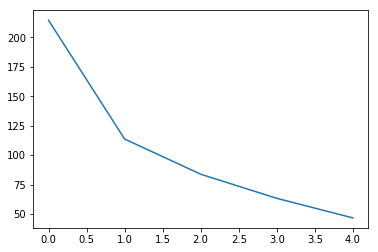

CPU times: user 7h 35min 3s, sys: 2h 51min 26s, total: 10h 26min 29s
Wall time: 5h 1min 53s


In [9]:
# %time train_vgg16()
%time train_resnet18()

In [10]:
torch.save(resnet18.state_dict(), 'resnet18_model.pkl')

#### Testing
Once finetuning is done we need to test it on the test set.

In [11]:
def test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = Variable(images)
        
        if (use_gpu):
            images = images.cuda()
            
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Test the models

In [12]:
# %time test(vgg16)
resnet18.load_state_dict(torch.load('resnet18_model.pkl'))
%time test(resnet18)

Accuracy of the network on the 1870 test images: 33 %
CPU times: user 3min 59s, sys: 1min 29s, total: 5min 29s
Wall time: 2min 47s


You can add more code to save the models if you want but otherwise this notebook is complete